In [21]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegem1d import DigFilter
%matplotlib inline
import matplotlib 
matplotlib.rcParams["font.size"] = 14

def ColeColePelton(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1-eta)*(1j*w*tau)**c))

def ColeColeSeigel(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1j*w*tau)**c))

time = np.logspace(-6,np.log10(0.01), 41)
# plt.loglog(time, true, 'k', lw=1)
# plt.loglog(time, approx, 'r.')
# time = np.logspace(-3,np.log10(4), 41)
wt, tbase, omega_int = DigFilter.setFrequency(time)
frequency = omega_int / (2*np.pi)
siginf, eta0, tau0, c0 = 1., 0.5, 0.005, 0.5
sigma = ColeColePelton(frequency, siginf, eta0, tau0, c0)
sigTCole = DigFilter.transFiltImpulse(sigma, wt, tbase, omega_int, time, tol=1e-12)

In [22]:
wires = Maps.Wires(('eta', 1), ('tau', 1), ('c', 1))
taumap = Maps.ExpMap(nP=1)*wires.tau
survey = SESurvey()
dtrue = -sigTCole
survey.dobs = dtrue
m1D = Mesh.TensorMesh([np.ones(3)])
prob = SEInvImpulseProblem(m1D, etaMap = wires.eta, tauMap = taumap, cMap=wires.c)
prob.time = time
prob.pair(survey)
m0 = np.r_[eta0, np.log(tau0), c0]

In [23]:
perc = 0.01
dmisfitpeta = DataMisfit.l2_DataMisfit(survey)
dmisfitpeta.W = 1/(abs(survey.dobs)*perc)
reg = Regularization.Simple(m1D)
opt = Optimization.ProjectedGNCG(maxIter = 10)
invProb = InvProblem.BaseInvProblem(dmisfitpeta, reg, opt)
# Create an inversion object
target = Directives.TargetMisfit()
betaSch = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
# invProb.beta = 0.
inv = Inversion.BaseInversion(invProb, directiveList=[betaSch, target])
reg.mref = 0.*m0
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
opt.tolX = 1e-20
opt.tolF = 1e-20
opt.tolG = 1e-20
opt.eps = 1e-20
# opt.lower = 0.
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  4.82e+04  4.79e+01  4.83e+04    3.93e+05      0              
   1  1.00e+00  1.91e+04  4.82e+01  1.92e+04    2.80e+05      0              
   2  1.00e+00  9.15e+03  4.82e+01  9.20e+03    4.00e+04      0              
   3  1.00e+00  2.63e+03  7.38e+01  2.71e+03    8.43e+04      1   Skip BFGS  
   4  1.00e+00  4.99e+02  7.61e+01  5.75e+02    7.28e+03      0              
   5  1.00e+00  4.80e+02  7.56e+01  5.55e+02    3.74e+02      0              
   6  1.00e+00  4.80e+02  7.56e+01  5.55e+02   

In [24]:
def ColeSEImpulse(time, eta, tau, c):    
    return eta*c/time*((time/tau)**c)*np.exp(-(time/tau)**c)
def ColeSEImpulseApprox(time, eta, tau, c):    
    m = eta*c/(tau**c)    
    peta = m*time**(c-1.) * (1. - (time/tau)**c )  
    return peta

True      eta, tau and c = 5e-01, 5e-03 and 0.5
Initial   eta, tau and c = 5e-01, 5e-03 and 0.5
Estimated eta, tau and c = 4e-01, 1e-03 and 0.4


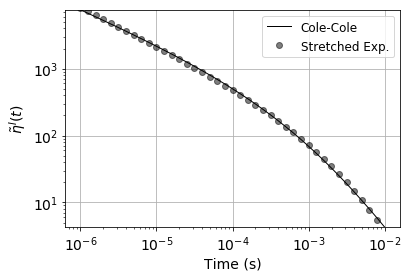

In [25]:
nskip=1
fig = plt.figure()
plt.loglog(prob.time, survey.dobs, 'k', lw=1)
plt.loglog(prob.time, invProb.dpred, 'ko', alpha = 0.5)
vmin, vmax = survey.dobs.min(), survey.dobs.max()
plt.ylim(vmin, vmax)
# legend(("pred", "obs"))
print ("True      eta, tau and c = %.e, %.e and %3.1f")%(eta0, tau0, c0)
print ("Initial   eta, tau and c = %.e, %.e and %3.1f")%(eta0, tau0, c0)
print ("Estimated eta, tau and c = %.e, %.e and %3.1f")%(mopt[0], np.exp(mopt[1]), mopt[2])

plt.xlabel("Time (s)")
plt.ylabel("$\\tilde {\eta}^I (t)$")
plt.legend(("Cole-Cole", "Stretched Exp."), fontsize = 12)
plt.grid(True)
# fig.savefig("")

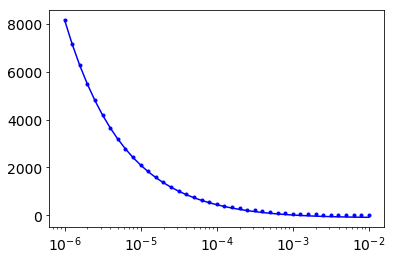

In [26]:
plt.semilogx(prob.time, ColeSEImpulseApprox(prob.time, mopt[0], np.exp(mopt[1]), mopt[2]), 'b-')
plt.semilogx(prob.time, ColeSEImpulse(prob.time, mopt[0], np.exp(mopt[1]), mopt[2]), 'b.')